In [1]:
import pandas as pd
import numpy as np
import nltk
from langdetect import detect
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation
from wordcloud import WordCloud
from PIL import Image

In [2]:
reviews=pd.read_csv('reviews.csv')

In [3]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 836586 entries, 0 to 836585
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   listing_id     836586 non-null  int64 
 1   id             836586 non-null  int64 
 2   date           836586 non-null  object
 3   reviewer_id    836586 non-null  int64 
 4   reviewer_name  836578 non-null  object
 5   comments       835850 non-null  object
dtypes: int64(3), object(3)
memory usage: 38.3+ MB


In [4]:
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,2595,17857,2009-11-21,50679,Jean,Notre séjour de trois nuits.\r\nNous avons app...
1,2595,19176,2009-12-05,53267,Cate,Great experience.
2,2595,19760,2009-12-10,38960,Anita,I've stayed with my friend at the Midtown Cast...
3,2595,34320,2010-04-09,71130,Kai-Uwe,"We've been staying here for about 9 nights, en..."
4,2595,46312,2010-05-25,117113,Alicia,We had a wonderful stay at Jennifer's charming...


In [5]:
reviews.dropna(inplace=True)

In [6]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 835842 entries, 0 to 836585
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   listing_id     835842 non-null  int64 
 1   id             835842 non-null  int64 
 2   date           835842 non-null  object
 3   reviewer_id    835842 non-null  int64 
 4   reviewer_name  835842 non-null  object
 5   comments       835842 non-null  object
dtypes: int64(3), object(3)
memory usage: 44.6+ MB


In [7]:
detect(reviews.iloc[2,5])

'en'

In [9]:
# replace non-english comments with 'Not English'
def non_eng(x):
    try:
        if detect(x) != 'en':
            return 'Not English'
    except:
        pass
# create a new column for whether the comments are in English
reviews['is_english']=reviews.comments.apply(non_eng)

In [10]:
# count how many comments are not in English
reviews[reviews['is_english'] == 'Not English'].count()

listing_id       94086
id               94086
date             94086
reviewer_id      94086
reviewer_name    94086
comments         94086
is_english       94086
dtype: int64

In [11]:
# Text preprocessing steps - remove numbers, captial letters and punctuation
import re
import string

alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x.lower())

reviews['comments'] = reviews.comments.map(alphanumeric).map(punc_lower)
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,is_english
0,2595,17857,2009-11-21,50679,Jean,notre séjour de trois nuits\r\nnous avons appr...,Not English
1,2595,19176,2009-12-05,53267,Cate,great experience,Not English
2,2595,19760,2009-12-10,38960,Anita,ive stayed with my friend at the midtown castl...,None
3,2595,34320,2010-04-09,71130,Kai-Uwe,weve been staying here for about nights enjo...,None
4,2595,46312,2010-05-25,117113,Alicia,we had a wonderful stay at jennifers charming ...,None


In [12]:
# create a new dataframe with only reviews that in English
new_df = reviews[reviews['is_english'] != 'Not English']

In [13]:
# sanity check
new_df.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,is_english
2,2595,19760,2009-12-10,38960,Anita,ive stayed with my friend at the midtown castl...,None
3,2595,34320,2010-04-09,71130,Kai-Uwe,weve been staying here for about nights enjo...,None
4,2595,46312,2010-05-25,117113,Alicia,we had a wonderful stay at jennifers charming ...,None
5,2595,1238204,2012-05-07,1783688,Sergey,hi to everyone\r\nwould say our greatest compl...,None
6,2595,1293632,2012-05-17,1870771,Loïc,jennifer was very friendly and helpful and her...,None


In [14]:
# drop is_english column 
new_df.drop(columns='is_english', inplace=True)

C:\Users\sandy\anaconda3_2nd_download\envs\metis\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [15]:
new_df.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
2,2595,19760,2009-12-10,38960,Anita,ive stayed with my friend at the midtown castl...
3,2595,34320,2010-04-09,71130,Kai-Uwe,weve been staying here for about nights enjo...
4,2595,46312,2010-05-25,117113,Alicia,we had a wonderful stay at jennifers charming ...
5,2595,1238204,2012-05-07,1783688,Sergey,hi to everyone\r\nwould say our greatest compl...
6,2595,1293632,2012-05-17,1870771,Loïc,jennifer was very friendly and helpful and her...


In [16]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 741756 entries, 2 to 836585
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   listing_id     741756 non-null  int64 
 1   id             741756 non-null  int64 
 2   date           741756 non-null  object
 3   reviewer_id    741756 non-null  int64 
 4   reviewer_name  741756 non-null  object
 5   comments       741756 non-null  object
dtypes: int64(3), object(3)
memory usage: 39.6+ MB


In [17]:
# remove \n 
new_df['comments'] = new_df['comments'].str.replace('\n', ' ')

<ipython-input-17-4a01bc5567f2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['comments'] = new_df['comments'].str.replace('\n', ' ')


In [18]:
new_df.iloc[3, 5]

'hi to everyone\r would say our greatest compliments to jennifer the host of midtown castle we spent in this lovely apartment in the heart of manhattan one month april   and will remember this time as ours best\r the apartment is pretty spacious and great located  the  th ave right around the corner there is everything you can need during your short or long stay jennifer is very friendly vigorous and very responsible host thanks her and highly recomend this apartment for everyone who are looking for a quiet place right in the center of the boiling midtown'

In [19]:
new_df.to_csv('reviews_english.csv', index=False)

(array([6.67092e+05, 6.24030e+04, 8.89600e+03, 2.12900e+03, 9.60000e+02,
        1.50000e+02, 6.20000e+01, 2.70000e+01, 1.80000e+01, 1.90000e+01]),
 array([1.000e+00, 1.070e+02, 2.130e+02, 3.190e+02, 4.250e+02, 5.310e+02,
        6.370e+02, 7.430e+02, 8.490e+02, 9.550e+02, 1.061e+03]),
 <BarContainer object of 10 artists>)

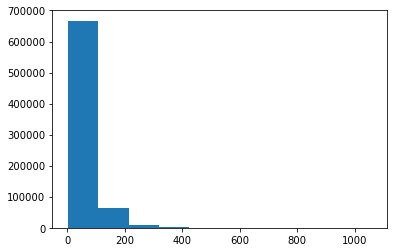

In [21]:
plt.hist(new_df.comments.str.count(' ') + 1)

In [2]:
eng_reviews = pd.read_csv('reviews_english.csv')

In [3]:
eng_reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,2595,19760,2009-12-10,38960,Anita,ive stayed with my friend at the midtown castl...
1,2595,34320,2010-04-09,71130,Kai-Uwe,weve been staying here for about nights enjo...
2,2595,46312,2010-05-25,117113,Alicia,we had a wonderful stay at jennifers charming ...
3,2595,1238204,2012-05-07,1783688,Sergey,hi to everyone\r would say our greatest compli...
4,2595,1293632,2012-05-17,1870771,Loïc,jennifer was very friendly and helpful and her...


In [5]:
eng_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 741756 entries, 0 to 741755
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   listing_id     741756 non-null  int64 
 1   id             741756 non-null  int64 
 2   date           741756 non-null  object
 3   reviewer_id    741756 non-null  int64 
 4   reviewer_name  741756 non-null  object
 5   comments       740667 non-null  object
dtypes: int64(3), object(3)
memory usage: 34.0+ MB


In [4]:
eng_reviews.dropna(inplace=True)

In [11]:
for review in eng_reviews['comments'].sample(10).values:
    print(review)
    print()

leslie was a charming and really helpful host her flat is cosy and nice and perfectly located

spacious studio apartment bassam  sam father  son are very professional and welcoming this apartment is perfect for couple with kids we brought our   month old daughter and it was perfect  host was nice to turn up the heat when it was cold kitchenette includes full size fridge conventional oven and portable stove definitely will stay again if we ever come back in the neighborhood

lara’s place was lovely meeting up to get keys was easy the room was clean and adorable i’d absolutely recommend it to anyone and would love to stay again

nora is a perfect hostess everything occurred as i was expecting it is an excellent location i could not wish nothing better it was an amazing experience

great place great location great host

this is a very nice place for family or few friends to live in the location is excellent as the subway station is just   mins walk and it also only takes   mins walk to ti

 # NMF

In [63]:
stopwords = nltk.corpus.stopwords.words('english')
newStopWords = ['nyc','york', 'stayed', 'really', 'person', 'definitely', 'thank', 'thanks', 'staying', 'looking', 'just', 'stay',
               'also', 'get', 'would', 'aa', 'aaa', 'aaaa', 'aaaaa', 'us', 'great', 'mirco', 'snes', 'myrdith', 'chandra', 'place', 
               'dolores', 'chen', 'even', 'monifa', 'dalton', 'well', 'mk', 'made', 'sahr', 'jt', 'thiago', 'hanna', 'shelly', 'faye',
               'jamilya', 'bertha', 'aya', 'loyda', 'mete', 'tiziana', 'curtis', 'haythem', 'tio', 'however', 'bit', 'regina', 'erica',
               'jenn','edgar', 'jeffrey', 'antonio', 'beatrix', 'tina', 'jesse', 'sammy', 'monika', 'freda', 'kelvin', 'sadie', 'mo',
               'aleksandra', 'elvin', 'farhan', 'jhon', 'jade', 'barry', 'ingrid', 'kem', 'heide', 'je', 'nice', 'like', 'nathan', 'chad',
               'yochi', 'raquel', 'kent', 'zach', 'christa', 'pamela', 'maralla', 'richelle', 'jeannie', 'bernardo', 'kyisvu', 'lauren',
               'gina', 'lucien', 'gus', 'herman', 'darnell', 'wasnt', 'joseph', 'iso', 'emily', 'tracy', 'lynn', 'charlene', 'ronnie', 
               'rosa', 'jackie', 'reka', 'dante', 'dominik', 'rhita', 'pela', 'mia', 'martin', 'sean', 'sara', 'kimberley', 'alexandre', 
               'though', 'soon', 'victor', 'caroline', 'viviana', 'ron', 'matt', 'nick', 'tim', 'robin', 'monica', 'xavier', 'patricia',
               'marjorie', 'teddy', 'maxime', 'loli', 'blanca', 'andressa', 'paulo', 'stacey', 'gillian', 'ross', 'dani', 'susi', 'agnes',
               'javier', 'charisse', 'didnt', 'susi', 'lisas', 'christa', 'elle', 'ever', 'lakshan', 'yuval', 'laurenta', 'everything', 
               'jalen', 'albert', 'joe', 'lucilu', 'greg', 'conrad', 'jeff', 'frances', 'zachs', 'nadir', 'cara', 'olzhas', 'rena',
               'petra', 'kat', 'laurens', 'gane', 'charles', 'martha', 'nora', 'jared', 'britt', 'abe', 'carrie', 'penny', 'harvin',
               'lory', 'vikas', 'remi', 'tonia', 'svetlana', 'seans','holly', 'got', 'dont', 'know', 'let', 'could', 'absolutely',
               'take', 'youre', 'quite', 'need', 'want', 'day', 'back', 'gave', 'enough', 'airbnb', 'anyone', 'ok', 'brooklyn', 'perfect',
               'highly', 'amazing', 'location', 'manhattan', 'good', 'night', 'super', 'one', 'overall', 'two', 'say', 'another', 'said', 
               'people', 'awesome', 'highly', 'loved', 'enjoyed', 'spot', 'excellent', 'lovely', 'time', 'feel', 'sure', 'wonderful', 'recommend',
               'recommended', 'upon', 'home', 'everyone', 'friends', 'apartment', 'beautiful', 'located', 'fantastic', 'needed', 'quick', 'quickly',
               'may', 'high', 'due', 'long', 'things', 'city', 'trip', 'family', 'next', 'every', 'much', 'minutes', 'much', 'felt', 'check', 'use', 'easy',
               'first', 'luggage', 'since', 'hours', 'able', 'never', 'go', 'best', 'see', 'house', 'lot', 'found', 'always', 'went', 'way',
               'nights', 'without', 'took', 'think', 'still', 'week', 'spent', 'told', 'find', 'guests', 'especially', 'make', 'visit',
               'better', 'met','experience', 'arrived','late','left','experience','morning','provided','early','flight','leave','came']
stopwords.extend(newStopWords)

In [64]:
# using tfidf vectorizer 
tf = TfidfVectorizer(stop_words=stopwords, min_df = 2, max_df=0.7)

word_matrix = tf.fit_transform(eng_reviews['comments'])

vocab = tf.get_feature_names()

In [65]:
len(vocab)

57760

In [53]:
# NMF run using 3 topics
nmf = NMF(n_components=3)

nmf.fit(word_matrix)

C:\Users\sandy\anaconda3_2nd_download\envs\metis\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


NMF(n_components=3)

In [54]:
topic_matrix = nmf.transform(word_matrix)

In [55]:
topic_matrix_df = pd.DataFrame(topic_matrix).add_prefix('topic_')

topic_matrix_df['comments'] = eng_reviews['comments']
topic_matrix_df.head()

,topic_0,topic_1,topic_2,comments
0,0.006478,0.003851,0.000000,ive stayed with my friend at the midtown castl...
1,0.007955,0.000000,0.000483,weve been staying here for about nights enjo...
2,0.002752,0.000000,0.001357,we had a wonderful stay at jennifers charming ...
3,0.006379,0.000000,0.013700,hi to everyone\r would say our greatest compli...
4,0.007152,0.000000,0.003025,jennifer was very friendly and helpful and her...


In [56]:
word_topic_matrix_df = pd.DataFrame(nmf.components_, columns=vocab).T.add_prefix('topic_')
word_topic_matrix_df.head()

,topic_0,topic_1,topic_2
aaaaand,0.000149,0.000000,0.000011
aaaand,0.000073,0.000002,0.000000
aaand,0.000170,0.000000,0.000121
aabout,0.000063,0.000000,0.000000
aadi,0.000105,0.000025,0.000000


In [57]:
# read 5 reviews in topic matrix
for review in topic_matrix_df.sort_values(by='topic_0', ascending=False).head(5)['comments'].values:
    print(review)
    print()

this place is very nice and clean the host was very friendly and helpful

the environment is engulfed in the indian culture expect the place to smell like fresh curry food all the time also be ready to spend a few dollars to do the drying for them because all the sheets are damp since they hang they hang dry cloths though the listing says entire town house it i actually just a small room with just a queen bed old couch and a nice bathroom

fantastic experience from the moment i walked into the door april was very kind and accommodating and gave me a lot of recommendations for food and drinks  the apartment is great for a weekend in williamsburg walking distance to everything love all the artwork and the general vibe of the apartment very clean as well  

lovely neighbourhood very close to the l train beautiful apartment theresa is super welcoming and clearly wants her guests to have a great time if you want to stay close but out of manhattan  and why wouldnt you want to experience a bi

topic seem to be about location?

In [58]:
for review in topic_matrix_df.sort_values(by='topic_1', ascending=False).head(5)['comments'].values:
    print(review)
    print()

the pictures do this place no justice it’s located in a beautiful area w so many things close by damon  kent were easy to get ahold of and had the best food recommendations you have to try peaches down the street everything you need is walking distance and they have a fully stocked kitchenbathroombedrooms such a cozy home you truly fall in love with it

my son and i recently spent   nights in lisas home and it was a wonderful experience the apartment is lovely and has everything you could possibly need or want it is brilliantly located in the best spot in soho and is close to every subway system in the city making it incredibly easy to get around lisa is a wonderful host and her attention and care in the lead up to and during our visit was very much appreciated her notes on what to do where to eat and how to get there were fabulous and we used them religiously to make sure we made the most of our time in nyc the check in process was so easy and we had no issues at all during our stay w

In [13]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [59]:
display_topics(nmf, vocab, 10)


Topic  0
clean, comfortable, room, close, subway, easy, space, quiet, neighborhood, restaurants

Topic  1
automated, canceled, posting, reservation, arrival, days, host, couple, late, departure

Topic  2
host, friendly, helpful, responsive, accommodating, kind, communication, best, welcoming, experience


In [21]:
word_topic_matrix_df.sort_values(by='topic_0', ascending=False).head(10)

,topic_0,topic_1,topic_2
great,11.112741,0.000000,0.000000
place,4.342581,2.867712,0.000000
location,3.013177,1.818869,0.000000
host,1.669739,1.709347,2.549100
value,0.448099,0.299908,0.000000
communication,0.413795,0.617036,0.004193
space,0.374152,1.258167,0.000000
recommend,0.356854,2.002127,0.000000
spot,0.278792,0.375804,0.000000
clean,0.275530,3.531404,0.000000


In [22]:
word_topic_matrix_df.sort_values(by='topic_1', ascending=False).head(10)

,topic_0,topic_1,topic_2
nice,0.000000,3.760930,0.0
clean,0.275530,3.531404,0.0
apartment,0.000000,3.164711,0.0
place,4.342581,2.867712,0.0
good,0.000000,2.458674,0.0
comfortable,0.010775,2.172361,0.0
room,0.000000,2.017205,0.0
recommend,0.356854,2.002127,0.0
close,0.026750,1.952934,0.0
subway,0.000000,1.951495,0.0


In [23]:
word_topic_matrix_df.sort_values(by='topic_2', ascending=False).head(10)

,topic_0,topic_1,topic_2
automated,0.000000,0.000000,4.401864
canceled,0.000000,0.000000,4.398378
posting,0.000000,0.000000,4.384911
reservation,0.000000,0.000000,4.280248
arrival,0.000000,0.000000,3.783040
days,0.000000,0.112075,3.438698
host,1.669739,1.709347,2.549100
day,0.000000,0.531333,0.242958
friendly,0.071143,1.139631,0.054039
wonderful,0.097553,1.047320,0.044837


In [27]:
def top_reviews(topic_matrix_df, topic, num_of_reviews):
    return (topic_matrix_df
            .sort_values(by=topic, ascending=False)
            .head(num_of_reviews)['comments']
            .values)

def top_words(word_topic_matrix_df, topic, n_of_words):
    return (word_topic_matrix_df
            .sort_values(by=topic, ascending=False)
            .head(n_of_words))[topic]

In [25]:
for review in top_reviews(topic_matrix_df, 'topic_0', 15):
    print(review)
    print()

great location great host great apartment i will definitely book again thanks for your host

really cute place tiny and cozy in a perfect location right off the street but once the door closes behind you you’d have no idea my husband and i had a great stay and would stay again in a heartbeat

stuarts place was wonderful well appointed with a beautiful terrace comfy couch and comfy bed its close to the train station and all the stuff youd like to do in williamsburg and greenpoint we enjoyed it so much that we tried to stay an extra day but some other guests were already coming

great host

i had a great stay at azzas the room is huge and private the bed and pillows super comfortable the bathroom was always pretty clean also really enjoyed meeting azza and her bf steve they are both very considerate easy going and helpful people finally the neighborhood was great nearby laundromat and a few restaurants i recommend toms diner and kimchi grill its a quiet and relaxing hood i guess the comm

In [28]:
top_words(word_topic_matrix_df, 'topic_0', 10)

great            11.112741
place             4.342581
location          3.013177
host              1.669739
value             0.448099
communication     0.413795
space             0.374152
recommend         0.356854
spot              0.278792
clean             0.275530
Name: topic_0, dtype: float64

In [29]:
for review in top_reviews(topic_matrix_df, 'topic_1', 15):
    print(review)
    print()

very good location the apartment is perfectly clean   ez is nice and very reactive   as i said to him the sofa bed is not comfy and must be changed or repaired

 all you need if you are looking for a place to sleep and take a bath clean near everything 

amazing stay  and highly recommend to future travelers everything is as advertised and more

this home was perfect for our quick trip to visit family it was the perfect location for us we were greeted by the hosts husband who showed us around and was very welcoming  ms marie responded very quickly to messages we needed to  check in an hour earlier and ms marie was able to accommodate i will be back thank you so much definitely a hidden gem

we really enjoyed our stay here its perfect for a sightseeing trip in nyc the subway is super close to the appartement and takes you easily to whererver you want to be

rhondas place was very clean and well decorated she is very accommodating and has excellent communication i was very happy with my 

In [30]:
top_words(word_topic_matrix_df, 'topic_1', 10)

nice           3.760930
clean          3.531404
apartment      3.164711
place          2.867712
good           2.458674
comfortable    2.172361
room           2.017205
recommend      2.002127
close          1.952934
subway         1.951495
Name: topic_1, dtype: float64

Describes the place

In [31]:
for review in top_reviews(topic_matrix_df, 'topic_2', 15):
    print(review)
    print()

the place is just perfect very clean modern and everything you need subway is super close isaac had great tips and was very welcoming we had a great stay

rena is really kind and helpful person i loved the stay

great apartment great hosts 

great location

horrible  if you are a peaceful person and want a place to stay  this is not it  i arrived a day late which i told the host  upon arrival she didn’t greet me  she wasn’t even home  she told me wait for someone to open the building door so i was outside cold  on top of that she’s so sarcastic she’s also weird  i am a nice person so all that drama and yelling isn’t for me  there was constant arguing in her loft 

good location comfortable bed  good shower very responsive host

dianas air bnb is the only place to stay in new york and is near perfection from an accommodation point of view the room is spacious clean stocked with everything you need to make it feel like home and has an incredibly comfortable bed and bathroom diana has tho

In [32]:
top_words(word_topic_matrix_df, 'topic_2', 10)

automated      4.401864
canceled       4.398378
posting        4.384911
reservation    4.280248
arrival        3.783040
days           3.438698
host           2.549100
day            0.242958
friendly       0.054039
wonderful      0.044837
Name: topic_2, dtype: float64

The reservation/booking process(whether the booking was canceled)

In [40]:
l = top_words(word_topic_matrix_df, 'topic_0', 10)

In [41]:
type(l)

pandas.core.series.Series

In [42]:
l_dict = l.to_dict()

In [43]:
l_dict

{'great': 11.112740837816473,
 'place': 4.342580834798545,
 'location': 3.0131767147782433,
 'host': 1.6697386829800334,
 'value': 0.4480990435225789,
 'communication': 0.4137953380185649,
 'space': 0.3741523258391307,
 'recommend': 0.35685392162386687,
 'spot': 0.27879199610338673,
 'clean': 0.27553011659480764}

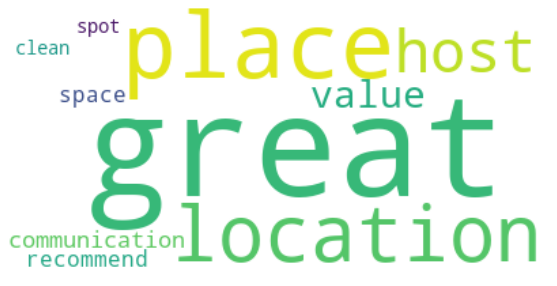

In [54]:
# word cloud for first topic
wc = WordCloud(background_color="white", max_words=10).generate_from_frequencies(l_dict)
plt.figure(figsize=[10,5])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.savefig('topic1')
plt.show()


In [50]:
second_top=top_words(word_topic_matrix_df, 'topic_1', 10)

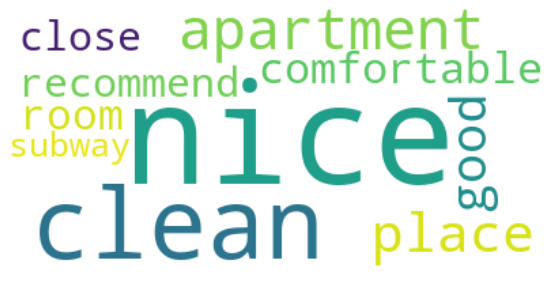

In [55]:
second_top_dict = second_top.to_dict()
wc = WordCloud(background_color="white", max_words=10).generate_from_frequencies(second_top_dict)
plt.figure(figsize=[10,5])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.savefig('topic2')
plt.show()


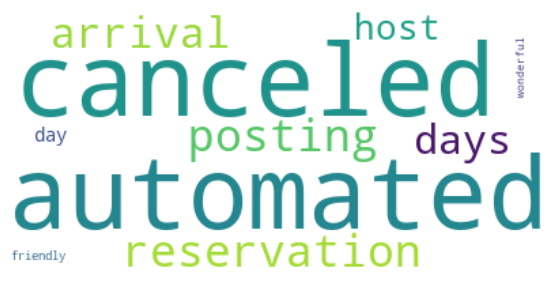

In [56]:
third_top = top_words(word_topic_matrix_df, 'topic_2', 10)
third_top_dict = third_top.to_dict()
wc = WordCloud(background_color="white", max_words=10).generate_from_frequencies(third_top_dict)
plt.figure(figsize=[10,5])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.savefig('topic3')
plt.show()

<AxesSubplot:>

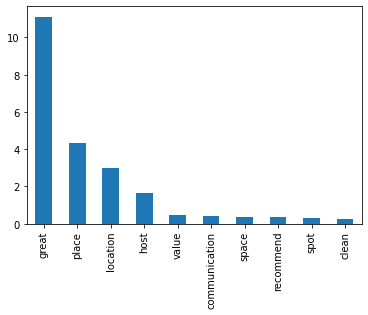

In [57]:
l.plot.bar()

In [59]:
l_df = l.to_frame()

In [61]:
l_df.reset_index(inplace=True)

In [62]:
l_df

,index,topic_0
0,great,11.112741
1,place,4.342581
2,location,3.013177
3,host,1.669739
4,value,0.448099
5,communication,0.413795
6,space,0.374152
7,recommend,0.356854
8,spot,0.278792
9,clean,0.275530


<AxesSubplot:xlabel='index', ylabel='topic_0'>

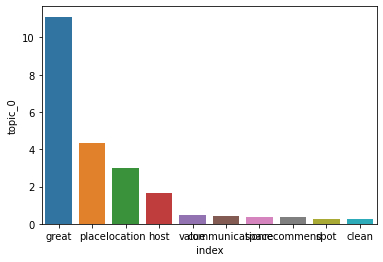

In [63]:
sns.barplot(x='index', y='topic_0', data=l_df)

In [66]:
# NMF using 6 topics
nmf_6 = NMF(n_components=6)

nmf_6.fit(word_matrix)

C:\Users\sandy\anaconda3_2nd_download\envs\metis\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


NMF(n_components=6)

In [67]:
six_topic_matrix = nmf_6.transform(word_matrix)

In [68]:
six_topic_matrix_df = pd.DataFrame(six_topic_matrix).add_prefix('topic_')

six_topic_matrix_df['comments'] = eng_reviews['comments']
six_topic_matrix_df.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,comments
0,0.004627,0.004011,0.000000,0.000273,0.000064,0.008166,ive stayed with my friend at the midtown castl...
1,0.009231,0.000000,0.000464,0.000000,0.000967,0.001578,weve been staying here for about nights enjo...
2,0.003439,0.000000,0.001397,0.000603,0.000027,0.000209,we had a wonderful stay at jennifers charming ...
3,0.007239,0.000000,0.014233,0.000943,0.000000,0.001070,hi to everyone\r would say our greatest compli...
4,0.008083,0.000000,0.003166,0.001916,0.000217,0.002008,jennifer was very friendly and helpful and her...


In [69]:
word_six_topic_matrix_df = pd.DataFrame(nmf_6.components_, columns=vocab).T.add_prefix('topic_')
word_six_topic_matrix_df.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5
aaaaand,0.000017,0.000000,0.000014,0.000151,0.000000,0.000007
aaaand,0.000103,0.000001,0.000000,0.000000,0.000000,0.000020
aaand,0.000230,0.000000,0.000116,0.000045,0.000000,0.000000
aabout,0.000067,0.000000,0.000000,0.000007,0.000000,0.000019
aadi,0.000043,0.000025,0.000000,0.000000,0.000018,0.000108


In [70]:
for review in six_topic_matrix_df.sort_values(by='topic_0', ascending=False).head(5)['comments'].values:
    print(review)
    print()

perfect 

we absolutely loved theresa’s place it is very stylish tasteful and exactly as described mattresses were super comfortable  high quality memory foam we loved the brooklyn area    mins by subway close by to times square we were a family of   travelling for   nights over new year  we hope to visit again one day 

everything was good nice location

good place to stay super clean and good location

lisa and simon were very gracious warm and engaging their beautiful apartment overlooks the hudson river and riverside park our stay was truely a wonderful experience would definitely go back again



In [71]:
display_topics(nmf_6, vocab, 10)


Topic  0
close, subway, neighborhood, restaurants, walk, quiet, station, area, helpful, around

Topic  1
automated, canceled, posting, reservation, arrival, days, host, couple, departure, spend

Topic  2
host, friendly, helpful, responsive, accommodating, kind, communication, welcoming, attentive, gracious

Topic  3
clean, quiet, spacious, cozy, convenient, communication, stylish, sparkling, safe, friendly

Topic  4
space, hosts, communication, cozy, plenty, stylish, lots, value, accommodating, responsive

Topic  5
comfortable, room, bed, bathroom, spacious, private, small, cozy, friendly, kitchen


In [72]:
word_six_topic_matrix_df.sort_values(by='topic_0', ascending=False).head(10)

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5
close,4.771361,0.000000,0.000000,0.000000,0.000000,0.000000
subway,4.408360,0.000000,0.000000,0.000000,0.000000,0.000000
neighborhood,2.465825,0.000000,0.022464,0.041702,0.084301,0.000000
restaurants,2.351001,0.000000,0.000000,0.000000,0.000000,0.000000
walk,1.927927,0.000000,0.000000,0.000000,0.000000,0.000000
quiet,1.821203,0.000000,0.000000,0.517649,0.047764,0.182078
station,1.765121,0.000000,0.000000,0.000000,0.000000,0.000000
area,1.762177,0.000000,0.034687,0.027419,0.104754,0.100461
helpful,1.605649,0.000000,0.510492,0.090264,0.033133,0.124995
around,1.547734,0.004126,0.000000,0.000000,0.008078,0.036333


In [74]:
# NMF using 5 topics
nmf_5 = NMF(n_components=5)

nmf_5.fit(word_matrix)

C:\Users\sandy\anaconda3_2nd_download\envs\metis\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


NMF(n_components=5)

In [75]:
five_topic_matrix = nmf_5.transform(word_matrix)

In [76]:
five_topic_matrix_df = pd.DataFrame(six_topic_matrix).add_prefix('topic_')

five_topic_matrix_df['comments'] = eng_reviews['comments']
five_topic_matrix_df.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,comments
0,0.004627,0.004011,0.000000,0.000273,0.000064,0.008166,ive stayed with my friend at the midtown castl...
1,0.009231,0.000000,0.000464,0.000000,0.000967,0.001578,weve been staying here for about nights enjo...
2,0.003439,0.000000,0.001397,0.000603,0.000027,0.000209,we had a wonderful stay at jennifers charming ...
3,0.007239,0.000000,0.014233,0.000943,0.000000,0.001070,hi to everyone\r would say our greatest compli...
4,0.008083,0.000000,0.003166,0.001916,0.000217,0.002008,jennifer was very friendly and helpful and her...


In [77]:
word_five_topic_matrix_df = pd.DataFrame(nmf_5.components_, columns=vocab).T.add_prefix('topic_')
word_five_topic_matrix_df.head()

,topic_0,topic_1,topic_2,topic_3,topic_4
aaaaand,0.000027,0.000000e+00,0.000013,0.000147,0.000000
aaaand,0.000115,9.713195e-07,0.000000,0.000000,0.000000
aaand,0.000182,0.000000e+00,0.000120,0.000035,0.000000
aabout,0.000070,0.000000e+00,0.000000,0.000012,0.000000
aadi,0.000113,2.522475e-05,0.000000,0.000010,0.000022


In [78]:
display_topics(nmf_5, vocab, 10)


Topic  0
close, subway, room, comfortable, neighborhood, restaurants, quiet, walk, area, helpful

Topic  1
automated, canceled, posting, reservation, arrival, days, host, couple, departure, spend

Topic  2
host, friendly, helpful, responsive, accommodating, communication, kind, welcoming, attentive, gracious

Topic  3
clean, comfortable, spacious, quiet, cozy, room, convenient, communication, stylish, sparkling

Topic  4
space, hosts, comfortable, communication, plenty, stylish, cozy, lots, value, accommodating


From the 5 topics we can deduce 4 topics:
# Topic 1: Location of Airbnb
# Topic 2: Booking process
# Topic 3: Host interactions
# Topic 4: Space